In [1]:
import pandas as pd
import seaborn as sns

# Beetlepalooza Beetle Measurement Data

This dataset has images of multiple beetles from each site (the individual beetles will be segmented out). Each image has multiple rows in the measurements CSV (2 per beetle annotation, one representing each of the two measurements performed on the beetles; there are multiple annotations per beetle, so it's more than 2 per).

We need to explore the variation in annotations. In `EDA-0-1` we discovered at least one instance of the length and width measurements of the elytra being transposed (since this generated a very obvious outlier). That analysis just looked at the first measurement available in each category for each individual. We want to compare all measurements for each individual to decide how they vary and which to use (or if we should take an average of the provided annotations, etc.).

This will also be important in deciding how to do the individual segmentation so that we can get images with just one beetle per image (suggestion was to use the provided coordinates to get an approximate bounding box and use SAM).

In [2]:
df = pd.read_csv("https://huggingface.co/datasets/imageomics/BeetlePalooza/resolve/15a82c862588b2e7b709b1aa982161d8c3a7c75f/BeetleMeasurements.csv", low_memory = False)
df.head()

,pictureID,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,scientificName,NEON_sampleID,siteID,site_name,plotID,user_name,workflowID,genus,species,individualID,file_name
0,A00000032929.jpg,"{""x1"": 815, ""y1"": 244, ""x2"": 892, ""y2"": 244}",77.0,1,ElytraLength,Yes,"{""x1"": 1055, ""y1"": 154, ""x2"": 1163, ""y2"": 149}",108.115679,1.404100,Carabus goryi,HARV_001.20180605.CARGOR.01,HARV,Harvard Forest & Quabbin Watershed NEON,HARV_001,IsaFluck,21652,Carabus,goryi,A00000032929_1,group_images/A00000032929.jpg
1,A00000032929.jpg,"{""x1"": 815, ""y1"": 244, ""x2"": 892, ""y2"": 244}",77.0,1,ElytraWidth,Yes,"{""x1"": 1053, ""y1"": 129, ""x2"": 1057, ""y2"": 179}",50.159745,0.651425,Carabus goryi,HARV_001.20180605.CARGOR.01,HARV,Harvard Forest & Quabbin Watershed NEON,HARV_001,IsaFluck,21652,Carabus,goryi,A00000032929_1,group_images/A00000032929.jpg
2,A00000032929.jpg,"{""x1"": 815, ""y1"": 244, ""x2"": 892, ""y2"": 244}",77.0,2,ElytraLength,Yes,"{""x1"": 1390, ""y1"": 150, ""x2"": 1314, ""y2"": 241}",118.562220,1.539769,Carabus goryi,HARV_001.20180605.CARGOR.01,HARV,Harvard Forest & Quabbin Watershed NEON,HARV_001,IsaFluck,21652,Carabus,goryi,A00000032929_2,group_images/A00000032929.jpg
3,A00000032929.jpg,"{""x1"": 815, ""y1"": 244, ""x2"": 892, ""y2"": 244}",77.0,2,ElytraWidth,Yes,"{""x1"": 1369, ""y1"": 136, ""x2"": 1407, ""y2"": 169}",50.328918,0.653622,Carabus goryi,HARV_001.20180605.CARGOR.01,HARV,Harvard Forest & Quabbin Watershed NEON,HARV_001,IsaFluck,21652,Carabus,goryi,A00000032929_2,group_images/A00000032929.jpg
4,A00000032929.jpg,"{""x1"": 815, ""y1"": 244, ""x2"": 892, ""y2"": 244}",77.0,3,ElytraLength,Yes,"{""x1"": 507, ""y1"": 378, ""x2"": 501, ""y2"": 487}",109.165013,1.417727,Carabus goryi,HARV_001.20180605.CARGOR.01,HARV,Harvard Forest & Quabbin Watershed NEON,HARV_001,IsaFluck,21652,Carabus,goryi,A00000032929_3,group_images/A00000032929.jpg


Column info:
  - `pictureID`: Name of the image: `<sample-barcode>.jpg`. Unique identifier for _group_ images, not for dataset. --- Probably should lowercase this.
  - `scalebar`: Pixel coordinates of the ruler/scalebar in the image.
  - `scm_pix`: Integer. The length in pixels of one cm on the scalebar.
  - `individual`: Integer. The beetle in the image to whom the measurements refer. Awaiting confirmation of how they are counted.
  - `structure`: Whether the measurement applies to the length or width of the elytra (`ElytraLength` or `ElytraWidth`, respectively).
  - `lying_straight`: Whether or not the beetle is "straight" in the image (`Yes` or `No`). Further guidance on this term's meaning would be helpful.
  - `coords_pix`: Pixel coordinates of the line marking the length or width of the elytra (green or purple --confirm which is which). Note that the lines are more than one pixel wide, which is why these coordinates form a rectangle.
  - `dist_pix`: Float. The length or width of the elytra (indicated by `structure`) as measured in pixels.
  - `dist_cm`: Float. The length or width of the elytra (indicated by `structure`) as measured in centimeters using the scalebar (the red line in the reference image denotes the pixel count for 1cm).
  - `scientificName`: Scientific name of the specimen (`<Genus> <species>`).
  - `NEON_sampleID	`: NEON identifier for the sample (576 unique IDs), prefixed by the `plotID`.
  - `siteID`: String. Identifier for the site from which the specimens were collected.
  - `site_name`: Name of field site from which the specimens were collected.
  - `plotID`: Identifier for the plot from which the specimens were collected (`<siteID>_<plot number>`).
  - `user_name`: Name of person inputting the information? (`<first><Last>`) or just their username in the system?
  - `workflowID`: Integer identifier for the workflow used...??
  - `genus`: Genus of the individual (generated by taking the first word in the `scientificName`).
  - `species`: Species of the individual (generated from the word(s) following the `genus` in the `scientificName`). There are 78 unique species labeled.
  - `individualID`: Unique identifier for the beetles (based on the assumed uniqueness of the `PictureID`), generated from `PictureID` (minus the `.jpg`) plus `_<individual>`.
  - `file_name`: Relative path to image from the root of the directory (`<group_images>/<pictureID>.jpg`); allows for image to be displayed in the dataset viewer alongside its associated metadata.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39064 entries, 0 to 39063
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pictureID       39064 non-null  object 
 1   scalebar        39064 non-null  object 
 2   cm_pix          39064 non-null  float64
 3   individual      39064 non-null  int64  
 4   structure       39064 non-null  object 
 5   lying_straight  39064 non-null  object 
 6   coords_pix      39064 non-null  object 
 7   dist_pix        39064 non-null  float64
 8   dist_cm         39064 non-null  float64
 9   scientificName  39030 non-null  object 
 10  NEON_sampleID   39064 non-null  object 
 11  siteID          39064 non-null  object 
 12  site_name       39064 non-null  object 
 13  plotID          39064 non-null  object 
 14  user_name       39064 non-null  object 
 15  workflowID      39064 non-null  int64  
 16  genus           39030 non-null  object 
 17  species         39002 non-null 

In [4]:
df.nunique()

pictureID           577
scalebar           1045
cm_pix              327
individual           99
structure             2
lying_straight        2
coords_pix        38724
dist_pix           4198
dist_cm           31566
scientificName       85
NEON_sampleID       576
siteID               30
site_name            43
plotID              144
user_name             3
workflowID            5
genus                36
species              78
individualID      11104
file_name           577
dtype: int64

## Exploring Multiple Annotations

We saw in `EDA-0-1` that there isn't any full duplication (as in, rows are not repeated), but clearly the same individuals have been annotated multiple times. We need to understand how much matches vs degree of variation with the others.

Let's check for duplication between `individualID` and `structure` to get a picture of how many elytra (length & width) measurements there are for each individual (do we have at least 2 for each?).

In [5]:
df["duplicate_annotation"] = df.duplicated(subset = ["individualID", "structure"], keep = "first")
df["duplicate_annotation"].value_counts()

duplicate_annotation
False    22208
True     16856
Name: count, dtype: int64

Considering we have 11,104 individuals, each of whom would get two measurements, we have at _most_ 8,428 individuals annotated twice (though we know there's at least one instance of an individual annotated three times).

In [6]:
for username in list(df.user_name.unique()):
    temp = df.loc[df["user_name"] == username].copy()
    print(f"{username} annotated {temp.pictureID.nunique()} images in {temp.shape[0]} entries, with {temp.individualID.nunique()} unique individuals (picID + individual)")

IsaFluck annotated 577 images in 22918 entries, with 11078 unique individuals (picID + individual)
ishachinniah annotated 235 images in 8122 entries, with 4053 unique individuals (picID + individual)
rileywolcheski annotated 234 images in 8024 entries, with 4004 unique individuals (picID + individual)


### Add number of annotations per individual

Let's add a column indicating the number of annotations per individual; we'll count each measurement (length _and_ width) in case there are any discrepancies (though that seems unlikely).

In [7]:
individuals_gp = df.groupby("individualID")

for individual, group in individuals_gp:
    df.loc[df["individualID"] == individual, "num_measurements"] = len(group)
    
df["num_measurements"].value_counts()

num_measurements
6.0     23856
2.0     14020
22.0      748
4.0       308
54.0       54
18.0       18
16.0       16
14.0       14
12.0       12
10.0       10
8.0         8
Name: count, dtype: int64

This suggests we have 7,010 individuals that are only annotated once, 77 annotated twice, 3,976 annotated 3 times, ..., 34 annotated 11 times, and one that somehow was annotated 27 times!

Let's separate out the edge cases 

In [8]:
df.loc[df["num_measurements"] == 54.0].nunique()

pictureID                1
scalebar                 3
cm_pix                   3
individual               1
structure                2
lying_straight           2
coords_pix              53
dist_pix                48
dist_cm                 51
scientificName           1
NEON_sampleID            1
siteID                   1
site_name                1
plotID                   1
user_name                3
workflowID               1
genus                    1
species                  1
individualID             1
file_name                1
duplicate_annotation     2
num_measurements         1
dtype: int64

At least all the variation is coming from the coordinates. Though, there is disagreement over whether or not the beetle is straight. I believe we should have consistency between `pictureID` and `NEON_sampleID`, as I would expect for `siteID` & `site_name`, but let's start by just checking that the following are consistent for each individual.

| column | unique values |
| ---- | --- |
| pictureID            | 577 |
| scientificName       | 85 |
| NEON_sampleID        | 576 |
| siteID               | 30 |
| site_name            | 43 |
| plotID               | 144 |


Would also expect to have the same number of distinct `dist_pix` and `dist_cm` since the latter is meant to be derived from the former, presumably by the same algorithm, but it seems the `cm_pix` varies...

In [9]:
id_info_cols = ["individualID", "pictureID", "scientificName", "NEON_sampleID", "siteID", "site_name", "plotID"]
df["duplicated_id_info"] = df.duplicated(subset = id_info_cols, keep = False)
df["duplicated_id_info"].value_counts()

duplicated_id_info
True    39064
Name: count, dtype: int64

In [10]:
# Check with keep in case of, e.g., 2 & 2 duplication
df["dupe_id_info"] = df.duplicated(subset = id_info_cols, keep = "first")
df["dupe_id_info"].value_counts()

dupe_id_info
True     27960
False    11104
Name: count, dtype: int64

That looks promising, we'll double check that's all unique individualIDs, then check for pure duplication on measurements for individuals. We also need to check on scale bar consistency (at least for the length and width measurements that get matched).

In [11]:
df.loc[~df["dupe_id_info"], "individualID"].nunique()

11104

Okay, good. These are indeed all consistent across individuals.


In [12]:
measurement_columns = ["pictureID", "individualID", "cm_pix", "lying_straight", "structure", "dist_pix", "dist_cm"]
df["dupe_meas"] = df.duplicated(subset = measurement_columns, keep = "first")
df["dupe_meas"].value_counts()

dupe_meas
False    39009
True        55
Name: count, dtype: int64

Ah, we have 55 potentially duplicated records. We checked previously for full duplication, so let's set `keep = False` and see where they differ.

In [13]:
df["dupe_record"] = df.duplicated(subset = measurement_columns, keep = False)
dupe_meas_df = df.loc[df["dupe_record"]].copy()
print(dupe_meas_df.shape)
dupe_meas_df.nunique()

(107, 26)


pictureID                10
scalebar                 13
cm_pix                    8
individual               19
structure                 2
lying_straight            1
coords_pix              106
dist_pix                 44
dist_cm                  46
scientificName            6
NEON_sampleID             9
siteID                    7
site_name                 7
plotID                    8
user_name                 2
workflowID                4
genus                     6
species                   6
individualID             38
file_name                10
duplicate_annotation      2
num_measurements          3
duplicated_id_info        1
dupe_id_info              2
dupe_meas                 2
dupe_record               1
dtype: int64

In [38]:
# what is the unique coords_pix?
temp = dupe_meas_df.copy()
temp["dupe_coords"] = temp.duplicated(subset = ["coords_pix"], keep = False)
temp.loc[temp["dupe_coords"]]

,pictureID,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,scientificName,...,file_name,duplicate_annotation,num_measurements,duplicated_id_info,dupe_id_info,dupe_meas,dupe_record,practical_meas_dupes,practical_meas_dupes_kept,dupe_coords
5551,A00000033675.jpg,"{""x1"": 939, ""y1"": 278, ""x2"": 1047, ""y2"": 280}",108.018517,7,ElytraWidth,Yes,"{""x1"": 1013, ""y1"": 397, ""x2"": 1035, ""y2"": 397}",22.0,0.203669,Cymindis neglecta,...,group_images/A00000033675.jpg,False,6.0,True,True,False,True,False,False,True
5647,A00000033675.jpg,"{""x1"": 939, ""y1"": 279, ""x2"": 1047, ""y2"": 281}",108.018517,7,ElytraWidth,Yes,"{""x1"": 1013, ""y1"": 397, ""x2"": 1035, ""y2"": 397}",22.0,0.203669,Cymindis neglecta,...,group_images/A00000033675.jpg,True,6.0,True,True,True,True,False,False,True


Interesting. Most of the variation is coming from the coordinates of the elytra measurement lines. The `scalebar` coordinates are also inconsistent within the same pictures, but that may be due to annotator. We have 107 entries representing 38 individuals (which should have 76 unique entries between them, so this is likely still a subset of their total number of records).

In [14]:
dupe_meas_df.user_name.value_counts()

user_name
IsaFluck        99
ishachinniah     8
Name: count, dtype: int64

In [15]:
potential_duplicate_meas = [col for col in list(dupe_meas_df.columns)[:-6] if col not in ["coords_pix", "user_name", "workflowID"]]
dupe_meas_df["practical_meas_dupes"] = df.duplicated(subset = potential_duplicate_meas, keep = False)
dupe_meas_df["practical_meas_dupes"].value_counts()

practical_meas_dupes
True     91
False    16
Name: count, dtype: int64

In [16]:
print(f"We have {dupe_meas_df.loc[dupe_meas_df['practical_meas_dupes'], 'individualID'].nunique()} individuals with true duplication (other than coordinates of the lines)")
print(f"We have {dupe_meas_df.loc[~dupe_meas_df['practical_meas_dupes'], 'individualID'].nunique()} individuals that don't have duplication in measurements (even beyond pixel lines)")

We have 30 individuals with true duplication (other than coordinates of the lines)
We have 8 individuals that don't have duplication in measurements (even beyond pixel lines)


We clearly have a few individuals in both groups...

In [17]:
print(dupe_meas_df.loc[dupe_meas_df['practical_meas_dupes'], 'structure'].value_counts())
print(dupe_meas_df.loc[~dupe_meas_df['practical_meas_dupes'], 'structure'].value_counts())

structure
ElytraWidth     62
ElytraLength    29
Name: count, dtype: int64
structure
ElytraWidth     14
ElytraLength     2
Name: count, dtype: int64


duplication is not balanced between structures either.

In [19]:
print(f"We have {dupe_meas_df.loc[dupe_meas_df['practical_meas_dupes'], 'pictureID'].nunique()} photos with true duplication (other than coordinates of the lines)")
print(f"We have {dupe_meas_df.loc[~dupe_meas_df['practical_meas_dupes'], 'pictureID'].nunique()} photos that don't have duplication in measurements (even beyond pixel lines)")

We have 7 photos with true duplication (other than coordinates of the lines)
We have 3 photos that don't have duplication in measurements (even beyond pixel lines)


Similarly for the group photos. 

In [20]:
dupe_meas_df.loc[dupe_meas_df["user_name"] == "ishachinniah", "practical_meas_dupes"].value_counts()

practical_meas_dupes
False    8
Name: count, dtype: int64

Okay, so the practical duplicates (measures that are consistent in all but coordinate location of the lines) are all from one user.

In [34]:
dupe_meas_df["practical_meas_dupes_kept"] = df.duplicated(subset = potential_duplicate_meas, keep = "first")
dupe_meas_df["practical_meas_dupes_kept"].value_counts()

practical_meas_dupes_kept
False    60
True     47
Name: count, dtype: int64

## Rough Comparison of Measurements

In [21]:
df_meas = pd.DataFrame({"elytraLength_pix": list(df.loc[df["structure"] == "ElytraLength", "dist_pix"]),
                        "elytraWidth_pix": list(df.loc[df["structure"] == "ElytraWidth", "dist_pix"]),
                        "elytraLength_cm": list(df.loc[df["structure"] == "ElytraLength", "dist_cm"]),
                        "elytraWidth_cm": list(df.loc[df["structure"] == "ElytraWidth", "dist_cm"]),
                        "user_name": list(df.loc[df["structure"] == "ElytraWidth", "user_name"]),
                        "genus": list(df.loc[df["structure"] == "ElytraWidth", "genus"]),
                        "species": list(df.loc[df["structure"] == "ElytraWidth", "species"]),
                        "individualID": list(df.loc[df["structure"] == "ElytraWidth", "individualID"])}) # should match up
df_meas.head()

,elytraLength_pix,elytraWidth_pix,elytraLength_cm,elytraWidth_cm,user_name,genus,species,individualID
0,108.115679,50.159745,1.404100,0.651425,IsaFluck,Carabus,goryi,A00000032929_1
1,118.562220,50.328918,1.539769,0.653622,IsaFluck,Carabus,goryi,A00000032929_2
2,109.165013,52.086467,1.417727,0.676448,IsaFluck,Carabus,goryi,A00000032929_3
3,105.000000,50.009999,1.363636,0.649481,IsaFluck,Carabus,goryi,A00000032929_4
4,103.576059,47.518417,1.345144,0.617122,IsaFluck,Carabus,goryi,A00000032929_5


Plot pixel measurements colored by `user_name`.

<Axes: xlabel='elytraLength_pix', ylabel='elytraWidth_pix'>

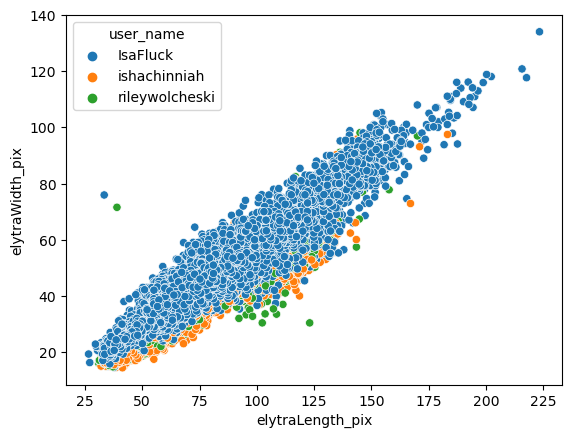

In [22]:
sns.scatterplot(df_meas, x = "elytraLength_pix", y = "elytraWidth_pix", hue = "user_name")

<Axes: xlabel='elytraLength_pix', ylabel='elytraWidth_pix'>

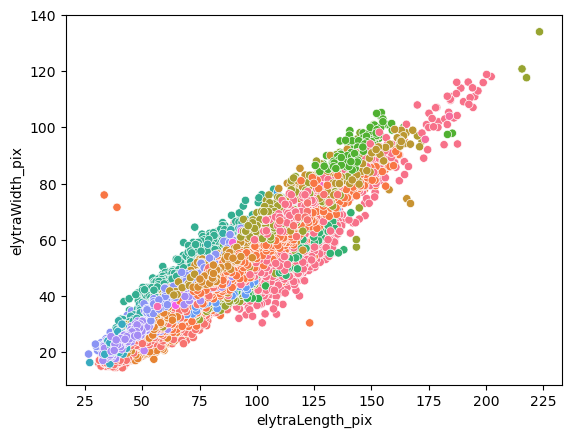

In [23]:
# color by genus

sns.scatterplot(df_meas, x = "elytraLength_pix", y = "elytraWidth_pix", hue = "genus", legend = False)

Plot cm measurements colored by `user_name`.

<Axes: xlabel='elytraLength_cm', ylabel='elytraWidth_cm'>

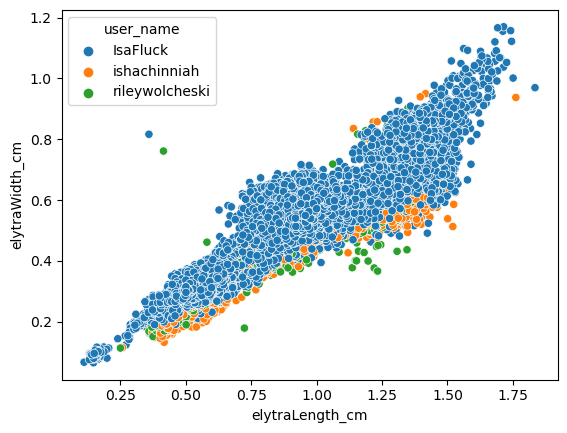

In [24]:
sns.scatterplot(df_meas, x = "elytraLength_cm", y = "elytraWidth_cm", hue = "user_name")

<Axes: xlabel='elytraLength_cm', ylabel='elytraWidth_cm'>

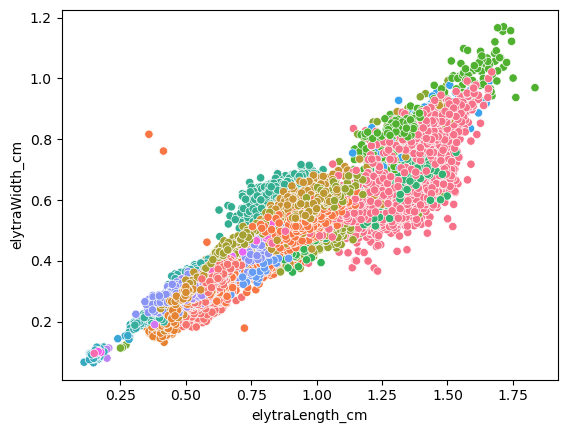

In [25]:
# color by genus

sns.scatterplot(df_meas, x = "elytraLength_cm", y = "elytraWidth_cm", hue = "genus", legend = False)

<Axes: xlabel='elytraLength_cm', ylabel='elytraWidth_cm'>

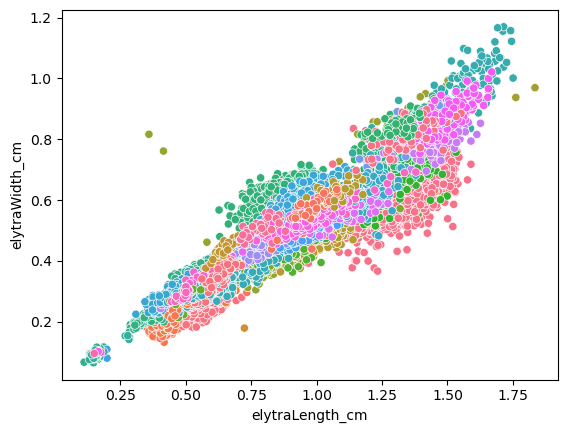

In [26]:
# color by species

sns.scatterplot(df_meas, x = "elytraLength_cm", y = "elytraWidth_cm", hue = "species", legend = False)

We would expect length to always be more than the width of the elytra based on where the measurements are made, so we can filter outliers based on a comparison of length to width.

![annotation image](beetles.png)

green and purple lines indicate the measurement used for the elytra length and width, respectively. The red line marks the pixels for 1cm.

In [27]:
df_meas["outliers"] = df_meas["elytraLength_pix"] < df_meas["elytraWidth_pix"]
df_meas.loc[df_meas["outliers"]]

,elytraLength_pix,elytraWidth_pix,elytraLength_cm,elytraWidth_cm,user_name,genus,species,individualID,outliers
7271,33.376639,75.953933,0.358806,0.816520,IsaFluck,Pterostichus,lachrymosus,A00000046078_10,True
10433,38.948684,71.561163,0.414324,0.761246,rileywolcheski,Pterostichus,lachrymosus,A00000046104_10,True


Isadora says the first one looks damaged, may lead to inconsistency. Looking at picture, the first one (`A00000046078_10`) is missing half the elytra (length-wise cut). `A00000046104_10` is just at an angle, length is definitely more than the width. We'll only be using Isadora's annotations anyway, so we'll just fix the first one (switch length and width) and not worry about the second.

In [36]:
df.loc[df["individualID"].isin(["A00000046078_10", "A00000046104_10"])]

,pictureID,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,scientificName,...,individualID,file_name,duplicate_annotation,num_measurements,duplicated_id_info,dupe_id_info,dupe_meas,dupe_record,num_pic_meas,max_individual
14542,A00000046078.jpg,"{""x1"": 1242, ""y1"": 307, ""x2"": 1335, ""y2"": 305}",93.021503,10,ElytraLength,Yes,"{""x1"": 1575, ""y1"": 797, ""x2"": 1570, ""y2"": 830}",33.376639,0.358806,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,False,6.0,True,False,False,False,66.0,11.0
14543,A00000046078.jpg,"{""x1"": 1242, ""y1"": 307, ""x2"": 1335, ""y2"": 305}",93.021503,10,ElytraWidth,Yes,"{""x1"": 1574, ""y1"": 812, ""x2"": 1649, ""y2"": 824}",75.953933,0.816520,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,False,6.0,True,True,False,False,66.0,11.0
14564,A00000046078.jpg,"{""x1"": 1242, ""y1"": 308, ""x2"": 1338, ""y2"": 306}",96.020831,10,ElytraLength,No,"{""x1"": 1575, ""y1"": 813, ""x2"": 1648, ""y2"": 823}",73.681748,0.767352,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,True,6.0,True,True,False,False,66.0,11.0
14565,A00000046078.jpg,"{""x1"": 1242, ""y1"": 308, ""x2"": 1338, ""y2"": 306}",96.020831,10,ElytraWidth,No,"{""x1"": 1568, ""y1"": 827, ""x2"": 1572, ""y2"": 798}",29.274562,0.304877,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,True,6.0,True,True,False,False,66.0,11.0
14586,A00000046078.jpg,"{""x1"": 948, ""y1"": 316, ""x2"": 1048, ""y2"": 313}",100.044990,10,ElytraLength,Yes,"{""x1"": 1575, ""y1"": 814, ""x2"": 1648, ""y2"": 824}",73.681748,0.736486,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,True,6.0,True,True,False,False,66.0,11.0
14587,A00000046078.jpg,"{""x1"": 948, ""y1"": 316, ""x2"": 1048, ""y2"": 313}",100.044990,10,ElytraWidth,Yes,"{""x1"": 1574, ""y1"": 799, ""x2"": 1570, ""y2"": 830}",31.256999,0.312429,Pterostichus lachrymosus,...,A00000046078_10,group_images/A00000046078.jpg,True,6.0,True,True,False,False,66.0,11.0
20810,A00000046104.jpg,"{""x1"": 1037, ""y1"": 301, ""x2"": 1124, ""y2"": 301}",87.000000,10,ElytraLength,Yes,"{""x1"": 1728, ""y1"": 412, ""x2"": 1769, ""y2"": 471}",71.847060,0.825828,Pterostichus lachrymosus,...,A00000046104_10,group_images/A00000046104.jpg,False,6.0,True,False,False,False,168.0,28.0
20811,A00000046104.jpg,"{""x1"": 1037, ""y1"": 301, ""x2"": 1124, ""y2"": 301}",87.000000,10,ElytraWidth,Yes,"{""x1"": 1709, ""y1"": 423, ""x2"": 1744, ""y2"": 401}",41.340053,0.475173,Pterostichus lachrymosus,...,A00000046104_10,group_images/A00000046104.jpg,False,6.0,True,True,False,False,168.0,28.0
20866,A00000046104.jpg,"{""x1"": 943, ""y1"": 305, ""x2"": 1037, ""y2"": 304}",94.005319,10,ElytraLength,Yes,"{""x1"": 1710, ""y1"": 421, ""x2"": 1744, ""y2"": 402}",38.948684,0.414324,Pterostichus lachrymosus,...,A00000046104_10,group_images/A00000046104.jpg,True,6.0,True,True,False,False,168.0,28.0
20867,A00000046104.jpg,"{""x1"": 943, ""y1"": 305, ""x2"": 1037, ""y2"": 304}",94.005319,10,ElytraWidth,Yes,"{""x1"": 1727, ""y1"": 413, ""x2"": 1766, ""y2"": 473}",71.561163,0.761246,Pterostichus lachrymosus,...,A00000046104_10,group_images/A00000046104.jpg,True,6.0,True,True,False,False,168.0,28.0


Let's check on those other couple outliers...

In [53]:
df_meas.loc[(df_meas["elytraLength_cm"] > .7) & (df_meas["elytraWidth_cm"] < .2)]

,elytraLength_pix,elytraWidth_pix,elytraLength_cm,elytraWidth_cm,user_name,genus,species,individualID,outliers
3871,123.044707,30.413813,0.72378,0.178902,rileywolcheski,Pterostichus,trinarius,A00000069270_1,False


This seems like a conversion error, also isn't part of annotations we'll be using.

In [54]:
df_meas.loc[(df_meas["elytraLength_cm"] > 1.7) & (df_meas["elytraWidth_cm"] < 1)]

,elytraLength_pix,elytraWidth_pix,elytraLength_cm,elytraWidth_cm,user_name,genus,species,individualID,outliers
4434,185.302455,97.948966,1.834588,0.969744,IsaFluck,Pasimachus,punctulatus,A00000046075_1,False
4435,183.174780,97.508974,1.761296,0.937586,ishachinniah,Pasimachus,punctulatus,A00000046075_1,False


In [55]:
df.loc[df["individualID"] == "A00000046075_1"]

,pictureID,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,scientificName,...,file_name,duplicate_annotation,num_measurements,duplicated_id_info,dupe_id_info,dupe_meas,dupe_record,num_pic_meas,max_individual,num_annotators
8868,A00000046075.jpg,"{""x1"": 1010, ""y1"": 246, ""x2"": 1111, ""y2"": 247}",101.004950,1,ElytraLength,Yes,"{""x1"": 834, ""y1"": 557, ""x2"": 1003, ""y2"": 633}",185.302455,1.834588,Pasimachus punctulatus,...,group_images/A00000046075.jpg,False,6.0,True,False,False,False,6.0,1.0,3.0
8869,A00000046075.jpg,"{""x1"": 1010, ""y1"": 246, ""x2"": 1111, ""y2"": 247}",101.004950,1,ElytraWidth,Yes,"{""x1"": 815, ""y1"": 601, ""x2"": 860, ""y2"": 514}",97.948966,0.969744,Pasimachus punctulatus,...,group_images/A00000046075.jpg,False,6.0,True,True,False,False,6.0,1.0,3.0
8870,A00000046075.jpg,"{""x1"": 1010, ""y1"": 247, ""x2"": 1114, ""y2"": 247}",104.000000,1,ElytraLength,No,"{""x1"": 833, ""y1"": 560, ""x2"": 1001, ""y2"": 633}",183.174780,1.761296,Pasimachus punctulatus,...,group_images/A00000046075.jpg,True,6.0,True,True,False,False,6.0,1.0,3.0
8871,A00000046075.jpg,"{""x1"": 1010, ""y1"": 247, ""x2"": 1114, ""y2"": 247}",104.000000,1,ElytraWidth,No,"{""x1"": 815, ""y1"": 602, ""x2"": 857, ""y2"": 514}",97.508974,0.937586,Pasimachus punctulatus,...,group_images/A00000046075.jpg,True,6.0,True,True,False,False,6.0,1.0,3.0
8872,A00000046075.jpg,"{""x1"": 899, ""y1"": 247, ""x2"": 1009, ""y2"": 248}",110.004545,1,ElytraLength,Yes,"{""x1"": 837, ""y1"": 558, ""x2"": 1001, ""y2"": 630}",179.108905,1.628195,Pasimachus punctulatus,...,group_images/A00000046075.jpg,True,6.0,True,True,False,False,6.0,1.0,3.0
8873,A00000046075.jpg,"{""x1"": 899, ""y1"": 247, ""x2"": 1009, ""y2"": 248}",110.004545,1,ElytraWidth,Yes,"{""x1"": 864, ""y1"": 514, ""x2"": 818, ""y2"": 605}",101.965681,0.926922,Pasimachus punctulatus,...,group_images/A00000046075.jpg,True,6.0,True,True,False,False,6.0,1.0,3.0


These all seem pretty consistent, most likely natural fluctuation.

### Save initial Measurement DataFrame with all Annotators for record

In [58]:
df_meas.to_csv("../metadata/all_measurements.csv", index = False)

## IsaFluck: Zooniverse limits to 99 individuals per image then resets count 

Ex: `A00000051542.jpg` has 122 individuals.

Also note, the inconsistency between unique images and `NEON_sampleID` is due to (`RMNP_014.20180709.CALADV.01`); there were too many individuals in the sample for Isadora to organize them all in one picture. She placed them in two pictures: `A00000051555_1` and `A00000051555_2`.


To try to address the too many individuals for Zooniverse issue, we'll add a count of number of measurements per image. Note, we still know there are some duplicate measurements, so let's just get the number of lines per image and the largest `individual` number.


In [32]:
meas_gp = df.groupby("pictureID")

for picID, group in meas_gp:
    if len(group)%2 != 0:
        print(f"picture {picID} has an uneven number of measurements recorded")
    df.loc[df["pictureID"] == picID, "num_pic_meas"] = len(group)
    df.loc[df["pictureID"] == picID, "max_individual"] = max(list(df.loc[df["pictureID"] == picID, "individual"].unique()))
    
print(df["num_pic_meas"].value_counts())
print("most meas: ", max(list(df["num_pic_meas"])), "least: ", min((list(df["num_pic_meas"]))))
print()
print("largest individual number recorded:")
print(df["max_individual"].value_counts())
print(f"least number of individuals in a single image: {min(list(df['max_individual']))}")

num_pic_meas
60.0     1920
126.0    1638
66.0     1518
78.0     1248
120.0    1200
         ... 
8.0        16
16.0       16
12.0       12
10.0       10
4.0         4
Name: count, Length: 92, dtype: int64
most meas:  642.0 least:  2.0

largest individual number recorded:
max_individual
99.0    2576
10.0    2058
11.0    1936
21.0    1932
13.0    1846
        ... 
5.0       70
3.0       66
4.0       60
2.0       16
8.0       16
Name: count, Length: 64, dtype: int64
least number of individuals in a single image: 1.0


Least number of measurements does correspond to the least number of individuals in an image. The challenge will be with the larger ones. We need to see how many unique measurements there are looking at just each annotator.

The best way to get a comparison would probably be to separate out the images where `max_individual < 99.0`, as we see below, the highest annotation count is for 214 annotations from each annotator (it seems maybe only a few had triple annotation, so we'll check on that then start splitting for comparison).

In [33]:
df.loc[df["num_pic_meas"] == 642.0].sample(2)

,pictureID,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,scientificName,...,individualID,file_name,duplicate_annotation,num_measurements,duplicated_id_info,dupe_id_info,dupe_meas,dupe_record,num_pic_meas,max_individual
13443,A00000046183.jpg,"{""x1"": 444, ""y1"": 303, ""x2"": 520, ""y2"": 304}",76.006579,10,ElytraWidth,Yes,"{""x1"": 1323, ""y1"": 1168, ""x2"": 1337, ""y2"": 1138}",33.105891,0.435566,Pterostichus lachrymosus,...,A00000046183_10,group_images/A00000046183.jpg,True,54.0,True,True,False,False,642.0,99.0
13258,A00000046183.jpg,"{""x1"": 444, ""y1"": 303, ""x2"": 520, ""y2"": 304}",76.006579,15,ElytraLength,Yes,"{""x1"": 1541, ""y1"": 175, ""x2"": 1601, ""y2"": 193}",62.641839,0.824163,Pterostichus lachrymosus,...,A00000046183_15,group_images/A00000046183.jpg,True,6.0,True,True,False,False,642.0,99.0


In [43]:
df.loc[df["num_pic_meas"] == 642.0, "user_name"].value_counts()

user_name
rileywolcheski    214
IsaFluck          214
ishachinniah      214
Name: count, dtype: int64

In [39]:
# check that one coords_pix dupe, since the only individual showing up is # 7:

df.loc[df["pictureID"] == "A00000033675.jpg", "max_individual"].values[0]

24.0

Yes, this one does have an actual measure duplication. Let's check who annotated that individual to see if it's two annotators or just one.

In [42]:
dupe_ID = df.loc[df["individualID"] == "A00000033675_7"]
dupe_ID[["scalebar", "cm_pix", "individual", "structure", "lying_straight", "coords_pix", "dist_pix", "dist_cm", "user_name"]]

,scalebar,cm_pix,individual,structure,lying_straight,coords_pix,dist_pix,dist_cm,user_name
5550,"{""x1"": 939, ""y1"": 278, ""x2"": 1047, ""y2"": 280}",108.018517,7,ElytraLength,Yes,"{""x1"": 1024, ""y1"": 399, ""x2"": 1022, ""y2"": 447}",48.041649,0.444754,IsaFluck
5551,"{""x1"": 939, ""y1"": 278, ""x2"": 1047, ""y2"": 280}",108.018517,7,ElytraWidth,Yes,"{""x1"": 1013, ""y1"": 397, ""x2"": 1035, ""y2"": 397}",22.000000,0.203669,IsaFluck
5598,"{""x1"": 821, ""y1"": 277, ""x2"": 938, ""y2"": 280}",117.038455,7,ElytraLength,Yes,"{""x1"": 1024, ""y1"": 398, ""x2"": 1023, ""y2"": 447}",49.010203,0.418753,rileywolcheski
5599,"{""x1"": 821, ""y1"": 277, ""x2"": 938, ""y2"": 280}",117.038455,7,ElytraWidth,Yes,"{""x1"": 1011, ""y1"": 399, ""x2"": 1036, ""y2"": 400}",25.019992,0.213776,rileywolcheski
5646,"{""x1"": 939, ""y1"": 279, ""x2"": 1047, ""y2"": 281}",108.018517,7,ElytraLength,Yes,"{""x1"": 1024, ""y1"": 399, ""x2"": 1023, ""y2"": 447}",48.010416,0.444465,ishachinniah
5647,"{""x1"": 939, ""y1"": 279, ""x2"": 1047, ""y2"": 281}",108.018517,7,ElytraWidth,Yes,"{""x1"": 1013, ""y1"": 397, ""x2"": 1035, ""y2"": 397}",22.000000,0.203669,ishachinniah


Okay, the `coords_pix` duplication is two annotators marking the same line. Seems 2 out of 3 matched on the width of the elytra.

### Compare Images with Multiple Annotators

In [44]:
multi_annotator = {}
double_annotator = []

for picID, group in meas_gp:
    num_annotators = df.loc[df["pictureID"] == picID, "user_name"].nunique()
    df.loc[df["pictureID"] == picID, "num_annotators"] = num_annotators
    if num_annotators > 1:
        multi_annotator[picID] = (df.loc[df["pictureID"] == picID, "max_individual"].values[0], df.loc[df["pictureID"] == picID, "num_pic_meas"].values[0])
        if num_annotators == 2:
            double_annotator.append(picID)

print(len(multi_annotator.keys()))
print(len(double_annotator))

235
1


In [45]:
double_annotator

['A00000051604.jpg']

In [46]:
multi_annotator[double_annotator[0]]

(49.0, 196.0)

In [49]:
ma_df = pd.DataFrame(data = {"pictureID": multi_annotator.keys(),
                             "max_individual": [multi_annotator[picID][0] for picID in multi_annotator.keys()],
                             "num_annotators": [3 if picID != double_annotator[0] else 2 for picID in multi_annotator.keys()],
                             "num_pic_meas": [multi_annotator[picID][1] for picID in multi_annotator.keys()]})

ma_df.head()

,pictureID,max_individual,num_annotators,num_pic_meas
0,A00000003356.jpg,1.0,3,6.0
1,A00000012427.jpg,15.0,3,90.0
2,A00000012429.jpg,21.0,3,126.0
3,A00000012430.jpg,13.0,3,78.0
4,A00000012431.jpg,21.0,3,126.0


In [51]:
ma_df["expected_num_meas"] = ma_df["num_pic_meas"]/ma_df["num_annotators"]
ma_df.nunique()

pictureID            235
max_individual        42
num_annotators         2
num_pic_meas          49
expected_num_meas     49
dtype: int64

In [52]:
print(max(list(ma_df["expected_num_meas"])), min(list(ma_df["expected_num_meas"])))

214.0 2.0


So this should contain images with as few as 1 and as many as 107 individuals.

### Save this df for record

In [57]:
ma_df.to_csv("../metadata/multi_annotator_count.csv", index = False)